In [2]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics.scorer import make_scorer, roc_auc_score
from subprocess import check_output
import os
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import scipy
from scipy import stats
import sys
%matplotlib inline

print "Checking files in data location ..."
print(check_output(["ls", "../data"]).decode("utf8"))

print "Checking files in exp location ..."
print(check_output(["ls", "../exp"]).decode("utf8"))

print "Done!"

Checking files in data location ...
creditcard.csv
creditcard.csv.zip
__init__.py
X.dat
y.dat

Checking files in exp location ...
Feature_Importance_RF_DM.csv

Done!


_Setting location of the data and loading it into a pandas dataframe_

In [3]:
print "#" * 150
print "Loading data ..."
dataDir = '../data'
expDir = '../exp'
data = os.path.join(dataDir, 'creditcard.csv')
df = pd.read_csv(data)
print "Data loaded succesfully into dataframe"

print"Data loaded with shape: {}".format(df.shape)
# print df.head(10)
# print df.columns
print df.describe()

######################################################################################################################################################
Loading data ...


Data loaded succesfully into dataframe
Data loaded with shape: (284807, 31)


                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [4]:
df.Time[df.Class == 1].describe()

count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

In [5]:
df.Time[df.Class == 0].describe()

count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64

In [10]:
np.set_printoptions(precision=16)
_, counts = np.unique(df['Class'], return_counts=True)

print "Percentage of fraudulent transactions : {}%".format(float(counts[1])/float(df.shape[0])*100)

[0 1]
[284315    492]
[(0, 284315), (1, 492)]
Percentage of fraudulent transactions : 0.172748563062%


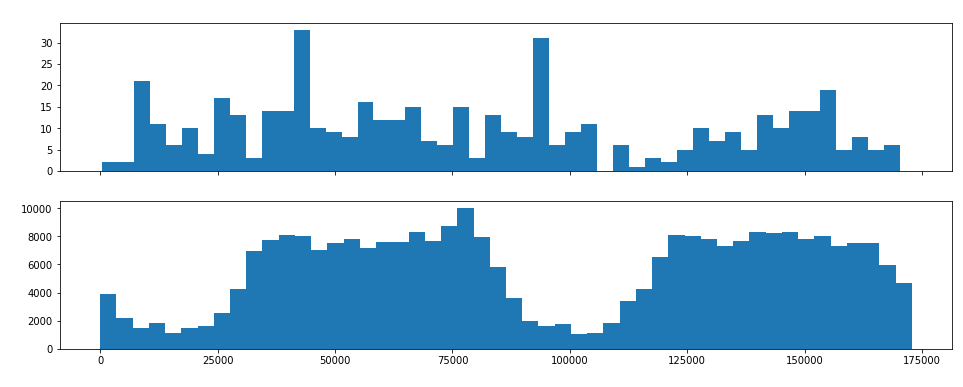

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins=bins)
ax1.set_title('Fraud', color="white")

ax2.hist(df.Time[df.Class == 0], bins=bins)
ax2.set_title('Normal', color="white")

plt.xlabel('Time (in Seconds)', color="white")
plt.ylabel('Number of Transactions', color="white")
plt.show()


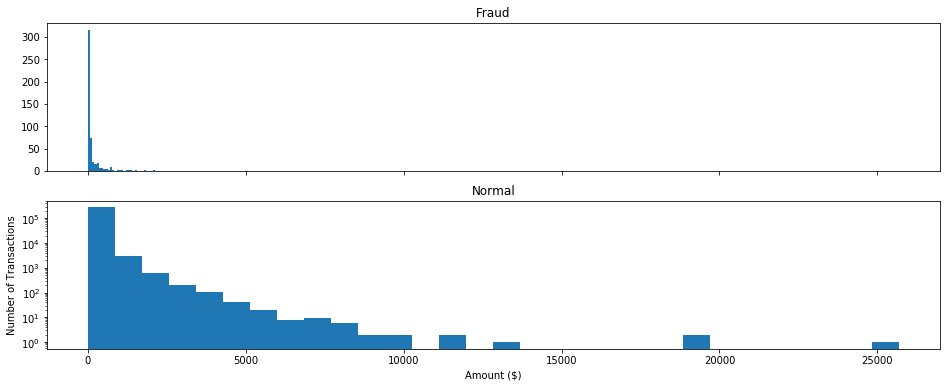

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins=bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins=bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [20]:
y = df.Class.values
X = df.drop(['Class'], axis=1)


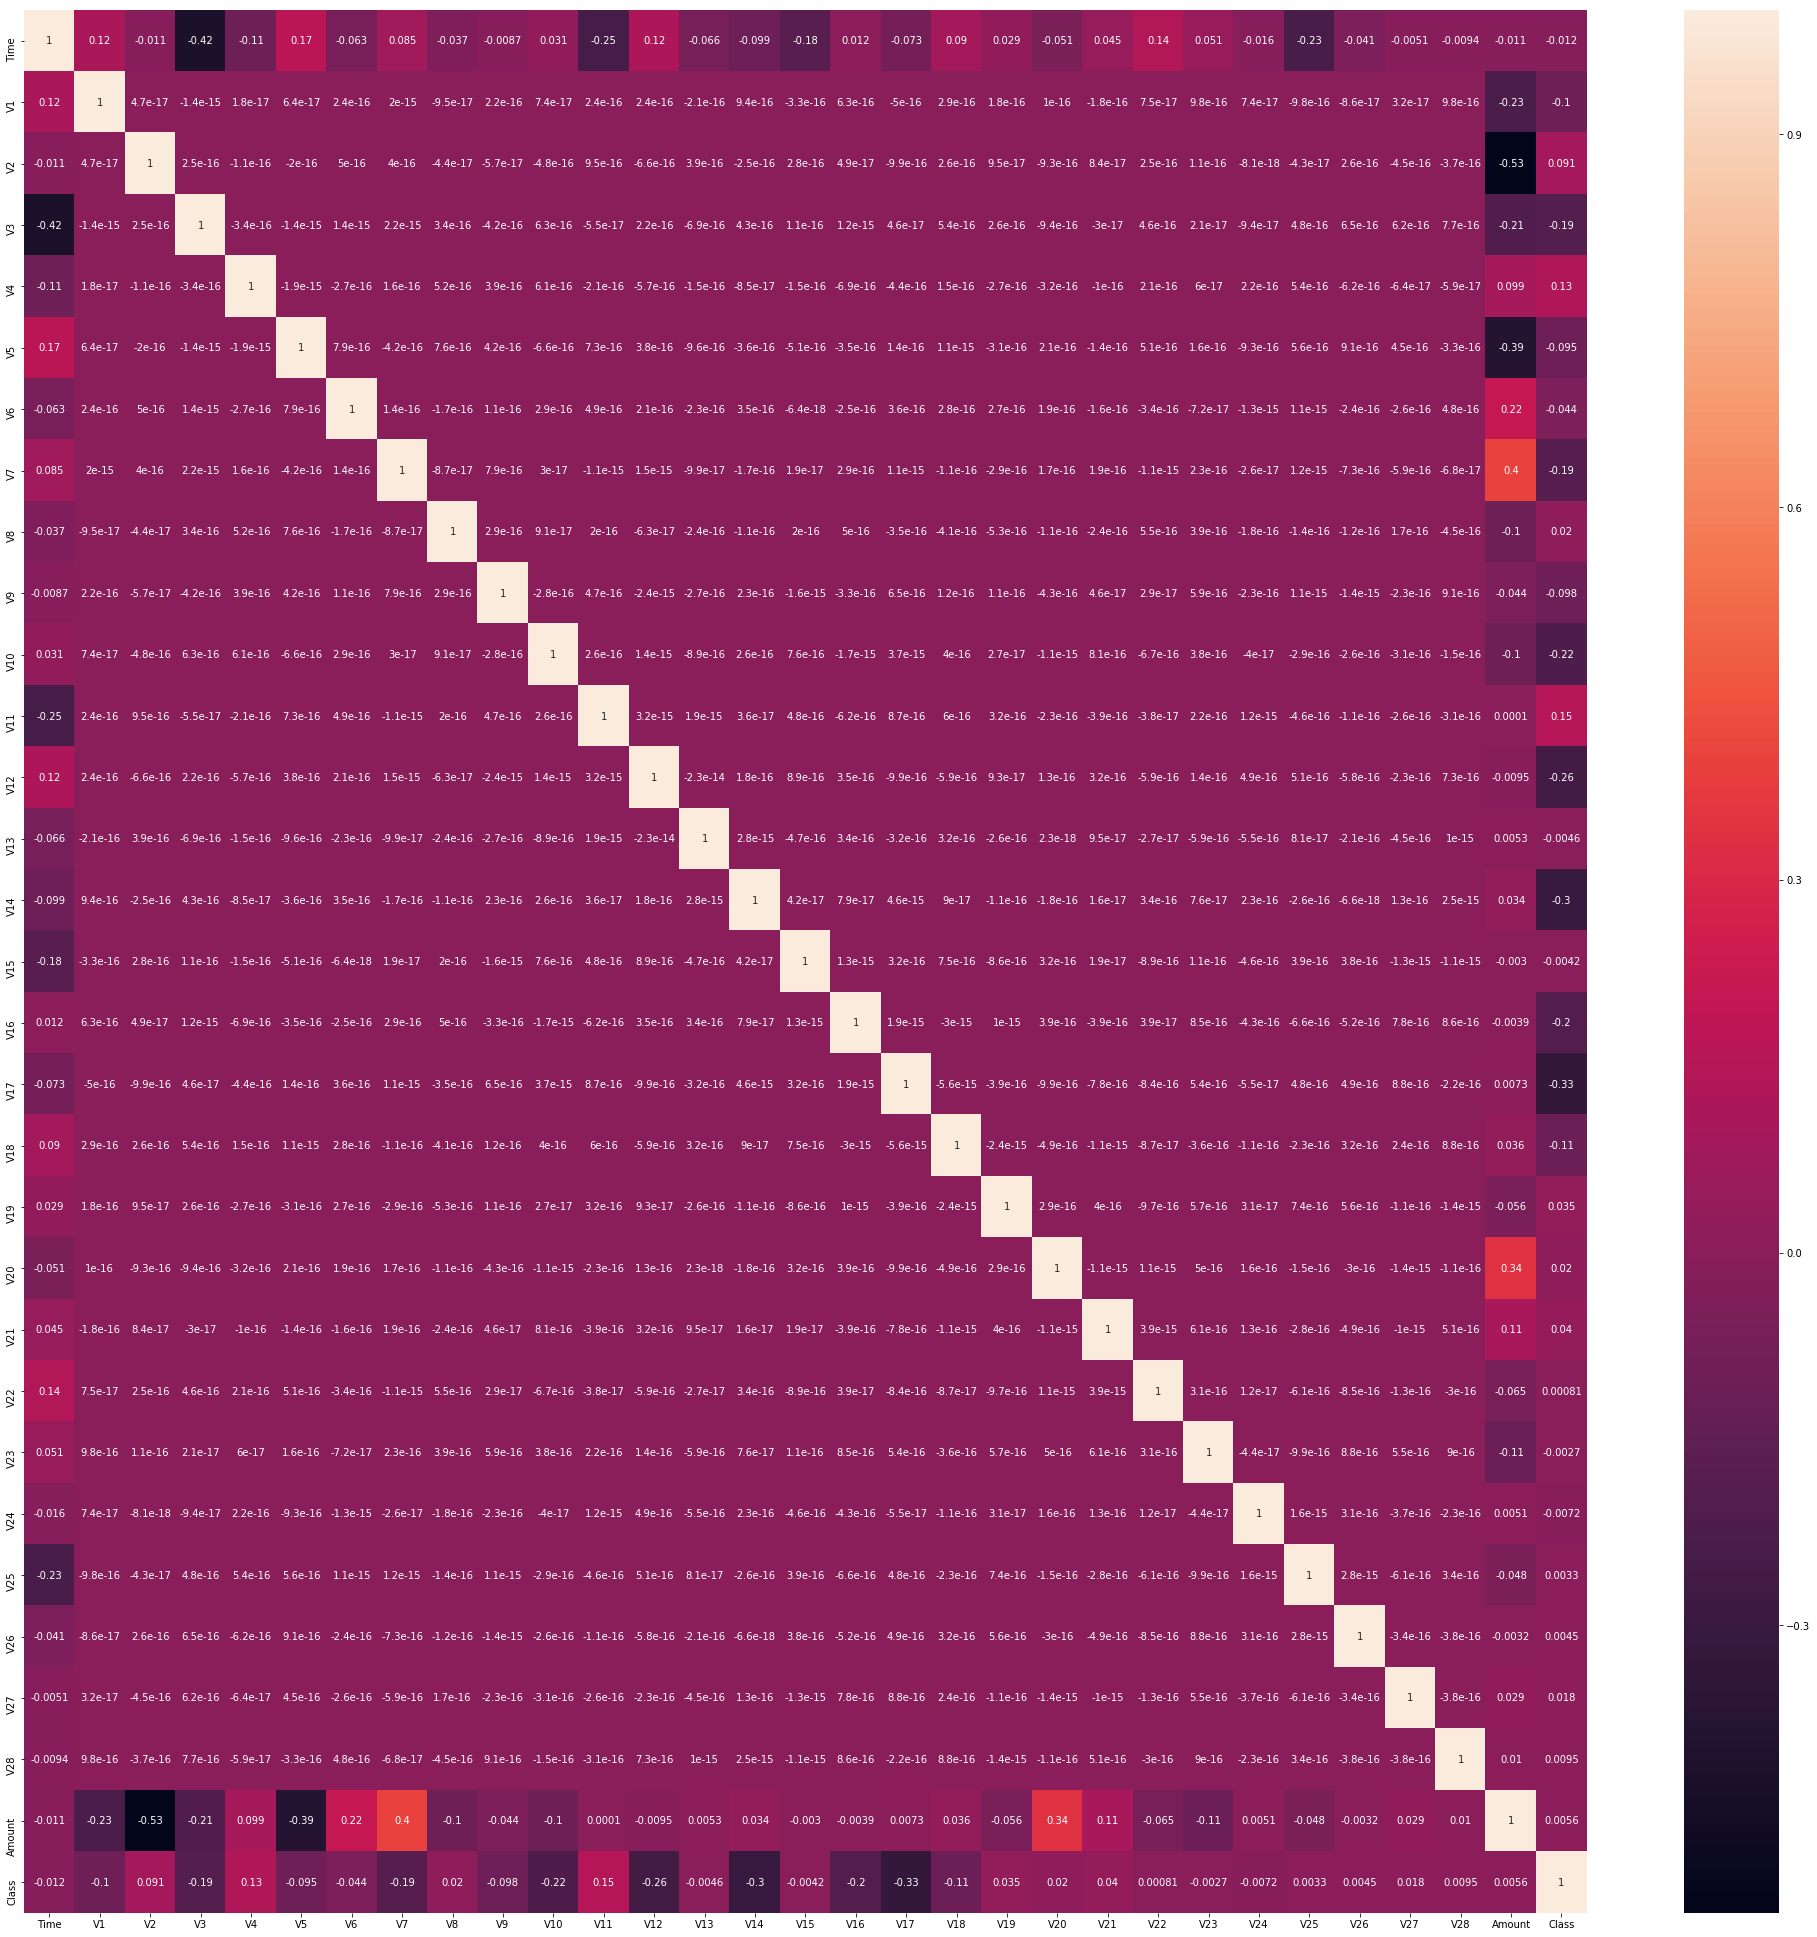

In [26]:
import seaborn as sns
plt.subplots(figsize=(35, 35))
sns.heatmap(df.corr(), annot=True)
plt.show()

Creating custom gini scorer for use with predictive models.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print "Shape of training set is: {}".format(X_train.shape)
print "Number of minority class in training set is: {}".format(len(y_train[y_train == 1]))

print "Spahe of validation set is: {}".format(X_test.shape)
print "Number of minority class in validation set is: {}".format(len(y_test[y_test == 1]))




Shape of training set is: (213605, 30)
Number of minority class in training set is: 379
Spahe of validation set is: (71202, 30)
Number of minority class in validation set is: 113


Creating custom gini scorer for use with predictive models.


In [10]:

def gini(actual, pred, cmpcol=0, sortcol=1):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    total_losses = all[:, 0].sum()
    gini_sum = all[:, 0].cumsum().sum() / total_losses
    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)


def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth) * -1


gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)


In [11]:
start_time_b = time.time()
rfb = RandomForestClassifier(n_jobs=-1)
rfb.fit(X_train, y_train)
elapsed_time_g = time.time() - start_time_b
score_RF = rfb.score(X_test, y_test)
predict_rf = rfb.predict(X_test)
score_gini_RF = gini_sklearn(predict_rf, y_test)
score_roc_RF = roc_auc_score(predict_rf, y_test)
print "Training Baseline for Random Forest took: %s" % str(elapsed_time_g)

print "Training Score Random Forest: %s" % score_RF
print "Gini Training score Random Forest: %s" % (score_gini_RF * -1)
print "ROC Training score Random Forest: %s" % (score_gini_RF * -1)

print "Training Baseline for Random Forest took: %s" % str(elapsed_time_g)

Training Baseline for Random Forest took: 4.01159000397
Training Score Random Forest: 0.999522485323446
Gini Training score Random Forest: 0.867159721487188
ROC Training score Random Forest: 0.867159721487188
Training Baseline for Random Forest took: 4.01159000397


In [12]:
print "Starting cross validation scoring ..."
score = cross_val_score(rfb, X, y, scoring=gini_scorer, cv=StratifiedShuffleSplit(n_splits=3, test_size=.5))
# print score
i = 1
for v in score:
    print "Validation score for fold {} is: {}".format(i, v)
    i += 1

Starting cross validation scoring ...


Validation score for fold 1 is: 0.885998254318
Validation score for fold 2 is: 0.860796363419
Validation score for fold 3 is: 0.828677229287


TN: 71081
FP 8
FN: 26
TP: 87
The recall for this model is : 0.769911504425
The precision for this model is : 0.915789473684


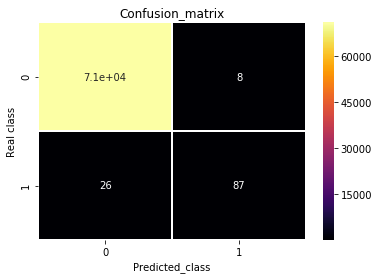

In [22]:
import seaborn as sns
tn, fp, fn, tp = confusion_matrix(y_test, predict_rf).ravel()
cnf_matrix = confusion_matrix(y_test, predict_rf)
print "TN: %s" % tn
print "FP %s" % fp
print "FN: %s" % fn
print "TP: %s" % tp
# print "The recall for this model is :", float(cnf_matrix[1, 1])/(float(cnf_matrix[1, 1])+float(cnf_matrix[1, 0]))
print "The recall for this model is :", float(tp)/(float(tp)+float(fn))
print "The precision for this model is :", float(tp)/(float(tp)+float(fp))

sns.heatmap(cnf_matrix, cmap="inferno", annot=True, linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

In [23]:
fimp = list(zip(X, rfb.feature_importances_))



In [24]:
dfimp = dict(fimp)
dfimp = pd.DataFrame(dfimp.items(), columns=['Metric', 'Importance'])
sdfimp = dfimp.sort_values('Importance', ascending=False)
print "Top 10 Feature importance Random Forest Training: "
print sum(sdfimp.head(10).Importance.values)
# dfimpCsv = 'Feature_Importance_RF_%s.csv' % 'DM'
# sdfimp.to_csv(os.path.join(expDir, dfimpCsv))

Top 10 Feature importance Random Forest Training: 
0.7944284224141401


Syntetic minority oversampling technique

In [25]:
sm = SMOTE(kind='regular')
X_sm, y_sm = sm.fit_sample(X_train, y_train)

print"Resampled Training set shale is: {}".format(X_sm.shape)
_, ncounts = np.unique(y_sm, return_counts=True)
print "Precentage of upsampled fraudulent tranzactions is {}".format(float(ncounts[1])/float(X_sm.shape[0])*100)


Resampled Training set shale is: (426452, 30)
Precentage of upsampled fraudulent tranzactions is 50.0


In [26]:
start_time_b = time.time()
urfb = RandomForestClassifier(n_jobs=-1)
urfb.fit(X_sm, y_sm)
elapsed_time_g = time.time() - start_time_b
score_RF_u = urfb.score(X_test, y_test)
predict_rf_u = urfb.predict(X_test)
score_gini_RF_u = gini_sklearn(predict_rf_u, y_test)
score_roc_RF_u = roc_auc_score(predict_rf_u, y_test)
print "Training (Upsampled) for Random Forest took: %s" % str(elapsed_time_g)

print "Score on hodlout for Random Forest: %s" % score_RF_u
print "Gini score on holdout for Random Forest: %s" % (score_gini_RF_u * -1)
print "ROC score for Random Forest: %s" % (score_gini_RF_u * -1)



Training (Upsampled) for Random Forest took: 7.25681209564
Score on hodlout for Random Forest: 0.9994522625768939
Gini score on holdout for Random Forest: 0.7879425639871324
ROC score for Random Forest: 0.7879425639871324


In [27]:
print "Starting cross validation scoring ..."
score = cross_val_score(rfb, X_sm, y_sm, scoring=gini_scorer, cv=StratifiedShuffleSplit(n_splits=3, test_size=.5))
# print score
i = 1
for v in score:
    print "Validation score for fold {} is: {}".format(i, v)
    i += 1

Starting cross validation scoring ...


Validation score for fold 1 is: 0.999859835166
Validation score for fold 2 is: 0.999916739189
Validation score for fold 3 is: 0.999850642227


Oversampled TN: 71066
TN: 71081
FP 8
Oversampled FP 23
FN: 26
Oversampled FN: 16
TP: 87
Oversampled TP: 97
The recall for oversampled model is : 0.769911504425
The precision for oversampled model is : 0.915789473684


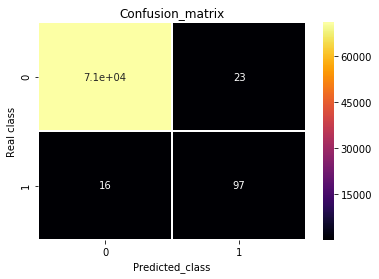

In [28]:
o_tn, o_fp, o_fn, o_tp = confusion_matrix(y_test, predict_rf_u).ravel()
cnf_matrix = confusion_matrix(y_test, predict_rf_u)
print "Oversampled TN: %s" % o_tn
print "TN: %s" % tn
print "FP %s" % fp
print "Oversampled FP %s" % o_fp
print "FN: %s" % fn
print "Oversampled FN: %s" % o_fn
print "TP: %s" % tp
print "Oversampled TP: %s" % o_tp
# print "The recall for this model is :", float(cnf_matrix[1, 1])/(float(cnf_matrix[1, 1])+float(cnf_matrix[1, 0]))
print "The recall for oversampled model is :", float(tp)/(float(tp)+float(fn))
print "The precision for oversampled model is :", float(tp)/(float(tp)+float(fp))

sns.heatmap(cnf_matrix, cmap="inferno", annot=True, linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()